# Homework 9

## Utilities 

In [40]:
#Imports Libraries 
# complex networks package - guide https://networkx.org/ 
import networkx as nx

# visualization packages - https://matplotlib.org/ 
import matplotlib.pyplot as plt
%matplotlib inline
from networkx.drawing.nx_agraph import graphviz_layout

# n-dinsional array tool - https://numpy.org/ 
import numpy as np

import matplotlib.colors as mcolors

import sklearn.manifold as sk

import sklearn.cluster as skc

import sklearn.decomposition as skd
import pandas as pd
import matplotlib.colors as mcolors

from node2vec import Node2Vec

import geopandas as gpd
# for Notebook
%matplotlib inline

## Question 2

### Ingesting the data 

In [5]:
df_nodes = pd.read_csv('/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/HW9/nodes.csv')
df_street = pd.read_csv('/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/HW9/streets.csv')
df_nodes.shape #Shows the head of the data


(4589, 8)

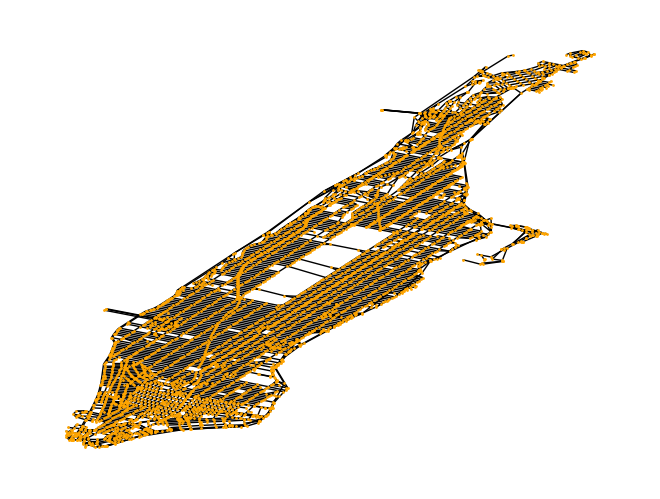

In [49]:
G = nx.Graph() #Creates the empty graph 
for index, row in df_nodes.iterrows(): 
    G.add_node(row['osmid'], pos=(row['x'], row['y'])) #Appends the graph G with the nodes
for index, row in df_street.iterrows():
    G.add_edge(row['u'], row['v'], weight=row['length']) #Appends the graph G with the length for the weights 
    
G.remove_edges_from(nx.selfloop_edges(G)) #Removes the self loops from the graph 

plt.figure() #Creates the figure 
pos = nx.get_node_attributes(G, "pos") #Gets the positional arguement 
nx.draw(G,pos, with_labels=False, node_size=1, node_color='orange') #Plots the graph 
plt.show() #Shows the figure 

### skip2gram approach

In [7]:

node2vec = Node2Vec(G, dimensions=32, walk_length=50, num_walks=100 , workers = 8) #Uses the node2vec library 


Generating walks (CPU: 8): 100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


In [11]:
model = node2vec.fit(window=10, min_count=1, batch_words=4) # https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

### Matrix factorization

In [19]:
node_ids= model.wv.index_to_key
node_ids =list(map(int, node_ids))
node_embeddings = model.wv.vectors #Matrix Factorization

### Plot Network Embeddings 

/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


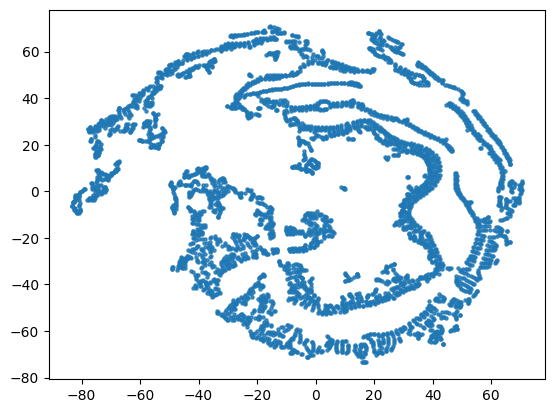

In [61]:
#TSNE 
tsne = sk.TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

plt.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1],s=5, alpha = 0.8)

In [ ]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, digits.target_names):
    plt.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1], c=c, label=label)
plt.legend()

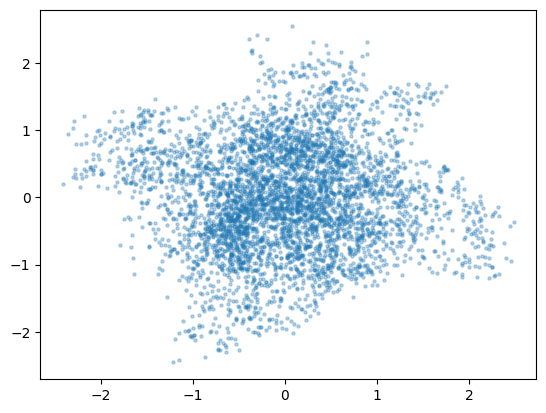

In [56]:
#PCA
pca = skd.PCA(n_components=2)
node_embeddings_2d_2 = pca.fit_transform(node_embeddings)

plt.scatter(node_embeddings_2d_2[:,0], node_embeddings_2d_2[:,1], s=5, alpha = 0.3)

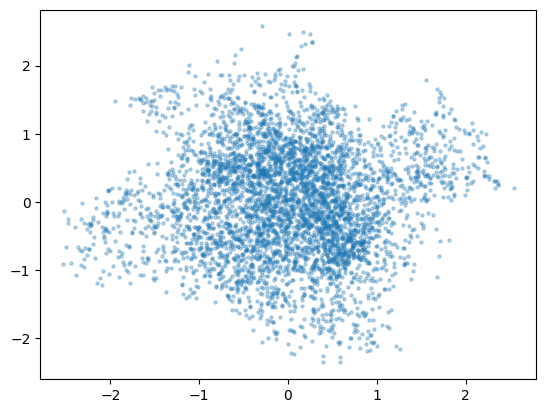

In [55]:
#SVD
svd = skd.TruncatedSVD(n_components=2)
node_embeddings_2d_3 = pca.fit_transform(node_embeddings)

plt.scatter(node_embeddings_2d_3[:,0], node_embeddings_2d_3[:,1],s=5, alpha = 0.3)

### KMeans Clustering 

In [25]:

kmeans = skc.KMeans(n_clusters=32, init='k-means++', n_init=10, random_state=0)
kmeans.fit(node_embeddings)

node_cluster_labels = pd.DataFrame(zip(node_ids, kmeans.labels_)).rename(columns={0:'osmid', 1:'cluster_label'})

nodes_clustered = df_nodes.merge(node_cluster_labels, on='osmid')



In [37]:
nodes_clustered

,Unnamed: 0,osmid,y,x,highway,street_count,ref,geometry,cluster_label
0,0,42421728,40.798048,-73.960044,traffic_signals,3,NaN,POINT (-73.9600437 40.7980478),5
1,1,42421731,40.798654,-73.961474,traffic_signals,4,NaN,POINT (-73.9614745 40.7986542),5
2,2,42421737,40.799244,-73.962873,traffic_signals,4,NaN,POINT (-73.9628734 40.7992437),5
3,3,42421741,40.800429,-73.965691,traffic_signals,4,NaN,POINT (-73.9656909 40.8004295),5
4,4,42421745,40.801398,-73.967996,traffic_signals,4,NaN,POINT (-73.9679955 40.8013981),5
...,...,...,...,...,...,...,...,...,...
4584,4584,9915469769,40.776062,-73.989341,NaN,1,NaN,POINT (-73.9893412 40.7760616),8
4585,4585,9971300853,40.754324,-73.997333,NaN,3,NaN,POINT (-73.9973333 40.7543237),30
4586,4586,9987259802,40.746052,-73.974873,traffic_signals,4,NaN,POINT (-73.9748726 40.746052),7
4587,4587,10128931543,40.820630,-73.958472,NaN,3,NaN,POINT (-73.9584715 40.8206298),14


/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/geopandas/plotting.py:649: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


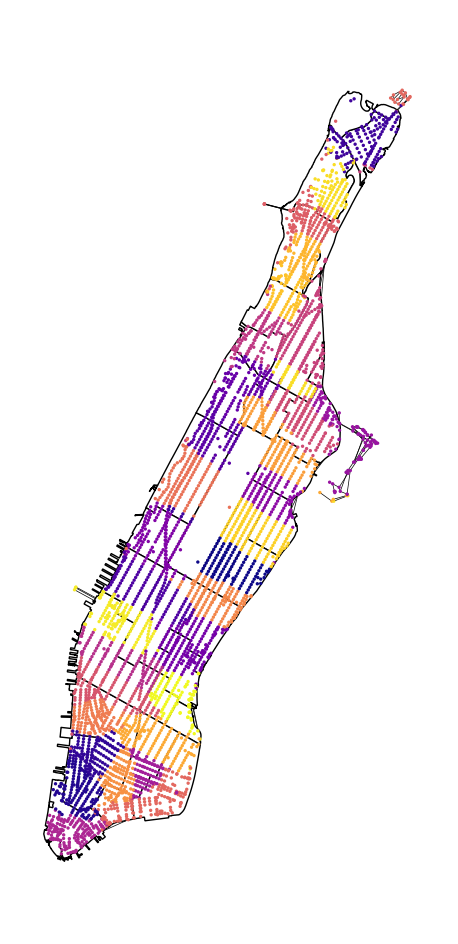

In [42]:
man_shape = gpd.read_file('shapefile/manhattan.shp')

pf, ax = plt.subplots(1, figsize=(12, 12))
nx.draw(G, pos, node_size=2, width=0.5, edge_color='black', node_color=nodes_clustered["cluster_label"], cmap = plt.cm.plasma, ax=ax)
man_shape.plot(axes=ax, color='white', edgecolor='black', ax=ax)
ax.set_axis_off()
plt.show()

In [43]:
#With SVD
kmeans = skc.KMeans(n_clusters=32, init='k-means++', n_init=10, random_state=0)
kmeans.fit(node_embeddings_2d_2)

node_cluster_labels = pd.DataFrame(zip(node_ids, kmeans.labels_)).rename(columns={0:'osmid', 1:'cluster_label'})

nodes_clustered = df_nodes.merge(node_cluster_labels, on='osmid')

/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/geopandas/plotting.py:649: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


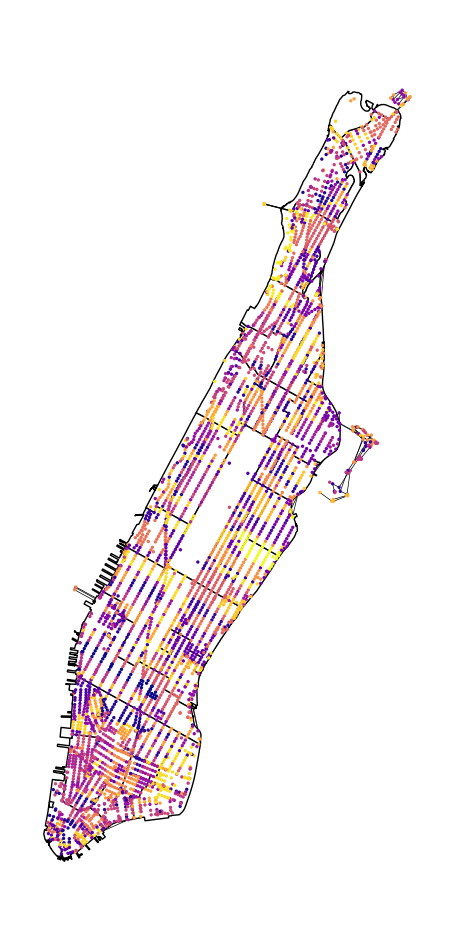

In [44]:
#With PCA
pf, ax = plt.subplots(1, figsize=(12, 12))
nx.draw(G, pos, node_size=2, width=0.5, edge_color='black', node_color=nodes_clustered["cluster_label"], cmap = plt.cm.plasma, ax=ax)
man_shape.plot(axes=ax, color='white', edgecolor='black', ax=ax)
ax.set_axis_off()
plt.show()

In [47]:
#With SVD 

kmeans = skc.KMeans(n_clusters=32, init='k-means++', n_init=10, random_state=0)
kmeans.fit(node_embeddings_2d_3)

node_cluster_labels = pd.DataFrame(zip(node_ids, kmeans.labels_)).rename(columns={0:'osmid', 1:'cluster_label'})

nodes_clustered = df_nodes.merge(node_cluster_labels, on='osmid')

/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/geopandas/plotting.py:649: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


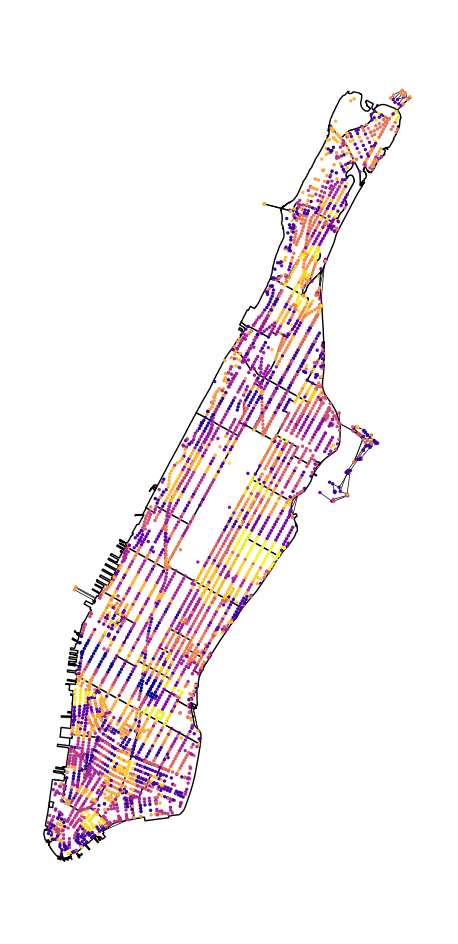

In [48]:
#With SVD
pf, ax = plt.subplots(1, figsize=(12, 12))
nx.draw(G, pos, node_size=2, width=0.5, edge_color='black', node_color=nodes_clustered["cluster_label"], cmap = plt.cm.plasma, ax=ax)
man_shape.plot(axes=ax, color='white', edgecolor='black', ax=ax)
ax.set_axis_off()
plt.show()